In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('cardio.csv')

In [3]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


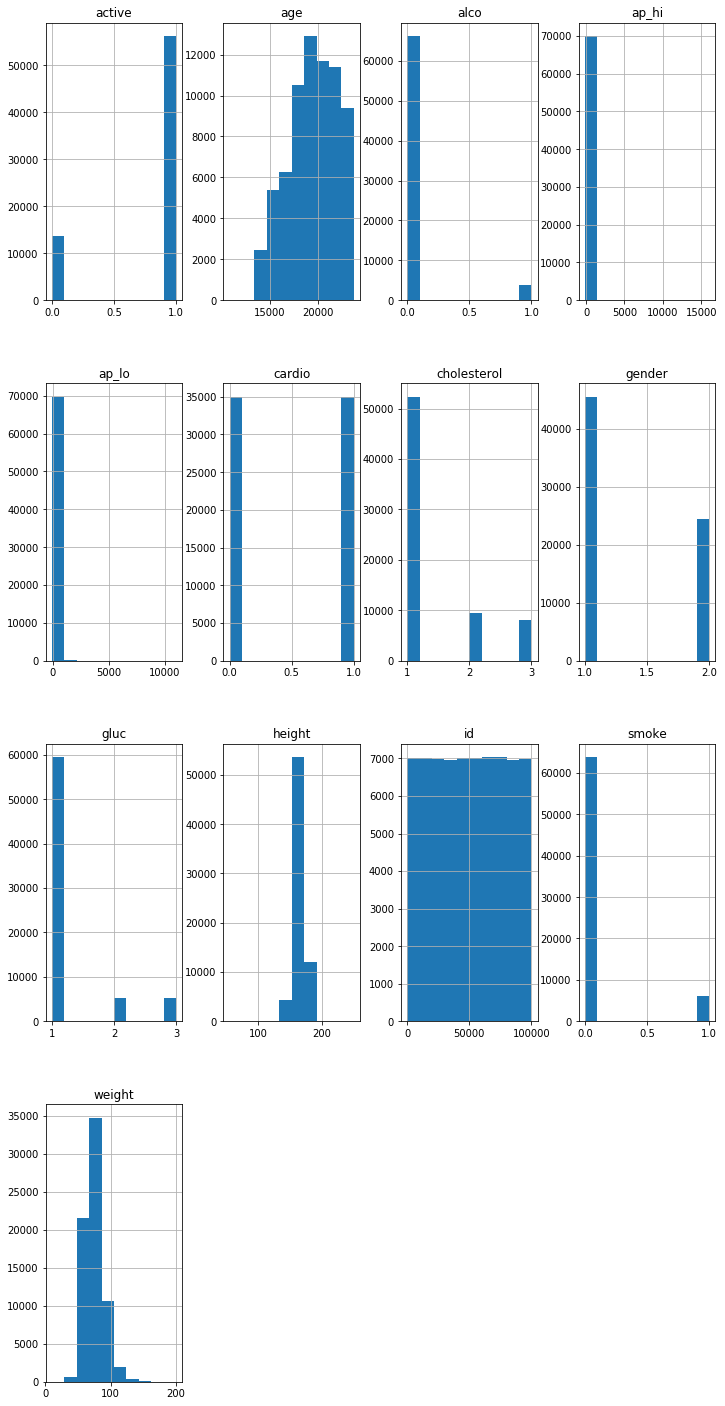

In [5]:
df.hist(figsize = (12, 25))
plt.show()

In [6]:
good = df[df['cardio']==0]
bad = df[df['cardio']==1]

outlier_fraction = len(bad)/float(len(good))
outlier_fraction

0.998800719568259

In [7]:
print("No. of normal : {}".format(len(good)))
print("No. of anomaly : {}".format(len(bad)))

No. of normal : 35021
No. of anomaly : 34979


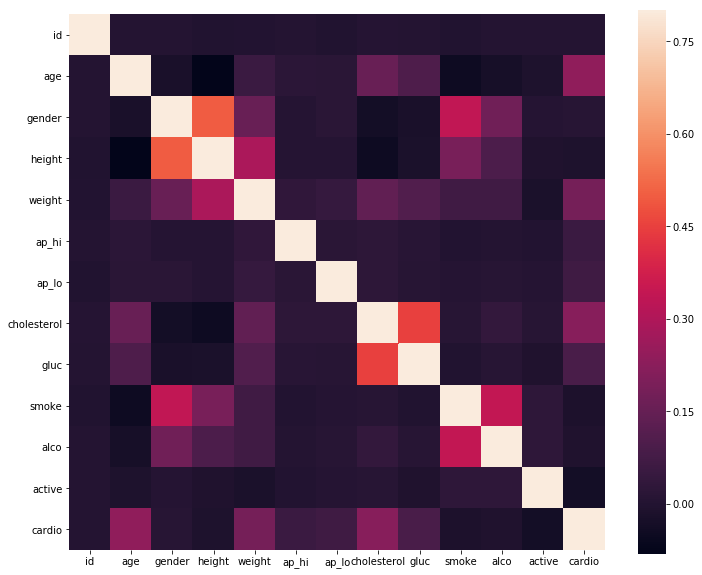

In [8]:
corrmat = df.corr()
fig = plt.figure(figsize = (12, 10))
sns.heatmap(corrmat, vmax = 0.8, square = True)
plt.show()

In [9]:
columns = df.columns.tolist()
columns = [c for c in columns if c not in ['cardio']]
target = 'cardio'

In [10]:
columns

['id',
 'age',
 'gender',
 'height',
 'weight',
 'ap_hi',
 'ap_lo',
 'cholesterol',
 'gluc',
 'smoke',
 'alco',
 'active']

In [11]:
X = df[columns]
y = df[target]
print(X.shape)
print(y.shape)

(70000, 12)
(70000,)


In [12]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [13]:
classifiers = {
    "Isolation Forest": IsolationForest(max_samples = len(X), contamination = outlier_fraction, random_state = 1 ),
    "Local Outlier Factor" : LocalOutlierFactor(n_neighbors = 20, contamination = outlier_fraction )
}
#fiting the data into different model and predicting the output 
n_outlier = len(bad)
for i, (clf_name, clf) in enumerate(classifiers.items()):
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y).sum()
    print('{}: {}'.format(clf_name, n_errors))
    print('Accuracy Score : {}'.format(accuracy_score(y, y_pred)))
    print((classification_report(y, y_pred)))

C:\Users\Acer\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\Acer\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Isolation Forest: 34993
Accuracy Score : 0.5001
              precision    recall  f1-score   support

           0       0.67      0.00      0.00     35021
           1       0.50      1.00      0.67     34979

   micro avg       0.50      0.50      0.50     70000
   macro avg       0.58      0.50      0.33     70000
weighted avg       0.58      0.50      0.33     70000



ValueError: contamination must be in (0, 0.5], got: 0.998801

In [14]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y, y_pred)

In [16]:
F_P = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
F_N = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
T_P = np.diag(cnf_matrix)
T_N = cnf_matrix.sum() - (F_P + F_N + T_P)

F_P = F_P.astype(float)
F_N = F_N.astype(float)
T_P = T_P.astype(float)
T_N = T_N.astype(float)

In [17]:
tp_rate = T_P/(T_P+F_N)
fp_rate = F_P/(F_P+T_N)

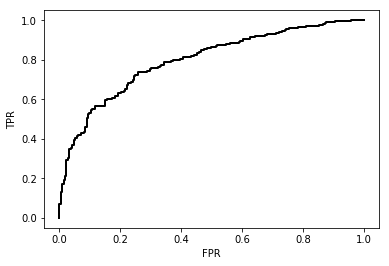

In [23]:
from sklearn.datasets import load_breast_cancer
X, y  = load_breast_cancer(return_X_y=True)

from sklearn.ensemble import IsolationForest

clf = IsolationForest(behaviour='new', max_samples=100,
                      random_state=0, contamination='auto')
clf.fit(X)
y_pred = clf.score_samples(X)

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y,y_pred)
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()